In [12]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [52]:
class SPNet(nn.Module):
    def __init__(self, IN=4, N=8, has_key=True):
        super(SPNet, self).__init__()
        self.IN = IN
        self.N = N

        self.fc1   = nn.Linear(in_features=N+IN if has_key else IN, out_features=N+IN)
        self.fc2   = nn.Linear(in_features=N+IN, out_features=N) ## 2*N????
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)
        
    def forward(self, x):
        #print(x.size())
        x = torch.sigmoid( self.fc1(x) )
        #print(x.size())
        x = torch.sigmoid( self.fc2(x) )
        #print(x.size())
        x = x.view(-1, 1, self.N)
        #print(x.size())
        x = torch.sigmoid( self.conv1(x) )
        #print(x.size())
        x = torch.sigmoid( self.conv2(x) )
        #print(x.size())
        x = torch.sigmoid( self.conv3(x) )
        #print(x.size())
        x = torch.tanh(    self.conv4(x) )
        #print(x.size())
        x = x.view(-1, 4)
        #print(x.size())
        return x

In [3]:
minibatch_size = 4096 # [256..4096]

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [33]:
square_error = lambda C1, C: torch.mean( torch.pow( C1 - C, 2) )
cov = lambda x, y: torch.mean( (x - x.mean()) * (y - y.mean()) )

loss_eve = square_error # on the single term C
loss_alicebob = (lambda public_error, bob_error, C_eve, C: 
    # square_error(D_pub, D) + square_error(D_bob, D)
      public_error           + bob_error
    + torch.abs( cov(C_eve, C) ))

In [6]:
# correlation matrix (symmetric positive definite matrix with ones in the diagonal)
C = torch.rand(size=(4,4), dtype=torch.float)
C = C - C*torch.eye(4) + torch.eye(4)
C = C * C.T
L = torch.cholesky(C).to(DEVICE)

# gen data example
K = torch.randint(low=0, high=2, size=(minibatch_size, 8), dtype=torch.float).to(DEVICE)*2-1
uncorrelated_ABCD = torch.randn(size=(minibatch_size, 4), dtype=torch.float).to(DEVICE)
ABCD = uncorrelated_ABCD @ L
ABCD

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU0 GeForce GTX 880M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


tensor([[-0.4399, -0.5073, -0.4115, -0.1633],
        [ 3.7598,  1.6772,  1.5024, -0.6567],
        [ 0.0101, -0.3084, -0.3537, -0.2422],
        ...,
        [-0.9076, -0.2570, -1.1682,  1.7152],
        [-1.0555, -0.2158, -0.5237, -0.7407],
        [ 1.0627,  0.0739, -0.8345,  0.6190]], device='cuda:0')

In [55]:
max_iter = 15000 #150000
ABs = []
Es  = []
PEs = []
BEs = []
EBs = []

A  = SPNet(IN=4, has_key=True).to(DEVICE)
B  = SPNet(IN=4, has_key=True).to(DEVICE)
E  = SPNet(IN=4, has_key=False).to(DEVICE)
BE = SPNet(IN=3, has_key=False).to(DEVICE)

A_optimizer  = optim.Adam(A.parameters(), lr=0.0008)
B_optimizer  = optim.Adam(B.parameters(), lr=0.0008)
E_optimizer  = optim.Adam(E.parameters(), lr=0.0008)
BE_optimizer = optim.Adam(BE.parameters(), lr=0.0008)

A.train()
B.train()
E.train()
BE.train()

start_time = time.time()
for ic in range(max_iter):
    for who, num_minibatches in [('AB', 1), ('E', 2)]:
        for _ in range(num_minibatches):
            K = torch.randint(low=0, high=2, size=(minibatch_size, 8), dtype=torch.float).to(DEVICE)*2-1
            uncorrelated_ABCD = torch.randn(size=(minibatch_size, 4), dtype=torch.float).to(DEVICE)
            ABCD = uncorrelated_ABCD @ L
            C = ABCD[:,2]
            D = ABCD[:,3]
            
            DENC = A(torch.cat((ABCD, K), dim=1))
            BOBD = B(torch.cat((DENC, K), dim=1))
            EVEC = E(DENC)
            BEVE = BE(DENC[:,0:3])

            D_pub       = DENC[:,3] # 4th col is D
            D_bob       = BOBD[:,3]
            C_eve       = EVEC[:,2] # 3rd col is C
            C_blind_eve = BEVE[:,2]
            
            if who == 'AB':
                public_error = square_error(D_pub, D)
                bob_error = square_error(D_bob, D)
                AB_loss = loss_alicebob(public_error, bob_error, C_eve, C)
                A_optimizer.zero_grad()
                B_optimizer.zero_grad()
                AB_loss.backward()
                A_optimizer.step()
                B_optimizer.step()

            if who == 'E':
                # Eve    
                E_loss = loss_eve(C_eve, C)
                E_optimizer.zero_grad()
                E_loss.backward(retain_graph=True) # ???
                E_optimizer.step()

                # Blind Eve
                BE_loss = loss_eve(C_blind_eve, C)
                BE_optimizer.zero_grad()
                BE_loss.backward()
                BE_optimizer.step()
                

    if ic % 1000 == 999:
        elapsed_time = time.time() - start_time            
        print("[{:6d}] PE {:2.4f} BE {:2.4f} AB_loss: {:2.4f} E_loss: {:2.4f} BE_loss {:2.4f} Elapsed Time: {}".format(
            ic+1, public_error, bob_error, AB_loss, E_loss, BE_loss,
            time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    ABs.append(AB_loss.item())
    Es.append(E_loss.item())
    EBs.append(BE_loss.item())
    PEs.append(public_error.item())
    BEs.append(bob_error.item())
    if AB_loss < 0.05 and E_loss > 0.5: # AB_loss < 0.05 and E_loss > 2
        break
                
            

[  1000] PE 0.9406 BE 0.9657 AB_loss: 1.9063 E_loss: 0.9656 BE_loss 0.9657 Elapsed Time: 00:00:37


[  2000] PE 0.2491 BE 0.2898 AB_loss: 0.5554 E_loss: 0.9428 BE_loss 0.9220 Elapsed Time: 00:01:13


[  3000] PE 0.1800 BE 0.1574 AB_loss: 0.3554 E_loss: 0.9567 BE_loss 0.8583 Elapsed Time: 00:01:50


[  4000] PE 0.1716 BE 0.1546 AB_loss: 0.3421 E_loss: 0.9254 BE_loss 0.8787 Elapsed Time: 00:02:27


[  5000] PE 0.1550 BE 0.1440 AB_loss: 0.3194 E_loss: 0.9526 BE_loss 0.9077 Elapsed Time: 00:03:03


[  6000] PE 0.1364 BE 0.1282 AB_loss: 0.2815 E_loss: 0.9694 BE_loss 0.9148 Elapsed Time: 00:03:40


[  7000] PE 0.1402 BE 0.1334 AB_loss: 0.2933 E_loss: 0.9547 BE_loss 0.8861 Elapsed Time: 00:04:17


[  8000] PE 0.1346 BE 0.1291 AB_loss: 0.2831 E_loss: 0.9618 BE_loss 0.8708 Elapsed Time: 00:04:54


[  9000] PE 0.1356 BE 0.1311 AB_loss: 0.2838 E_loss: 0.9500 BE_loss 0.8482 Elapsed Time: 00:05:30


[ 10000] PE 0.1490 BE 0.1448 AB_loss: 0.3104 E_loss: 0.9238 BE_loss 0.8156 Elapsed Time: 00:06:06


[ 11000] PE 0.1373 BE 0.1346 AB_loss: 0.2928 E_loss: 0.9675 BE_loss 0.8772 Elapsed Time: 00:06:43


[ 12000] PE 0.1319 BE 0.1303 AB_loss: 0.2798 E_loss: 0.9447 BE_loss 0.8731 Elapsed Time: 00:07:20


[ 13000] PE 0.1303 BE 0.1291 AB_loss: 0.2840 E_loss: 0.9367 BE_loss 0.8817 Elapsed Time: 00:07:57


[ 14000] PE 0.1385 BE 0.1375 AB_loss: 0.2959 E_loss: 0.9701 BE_loss 0.9243 Elapsed Time: 00:08:33


[ 15000] PE 0.1379 BE 0.1368 AB_loss: 0.2976 E_loss: 0.9109 BE_loss 0.8548 Elapsed Time: 00:09:09


In [62]:
# calculate eve improvement over blind_eve
E_improvement = list((torch.tensor(Es) - torch.tensor(BEs) / torch.tensor(BEs)).numpy())

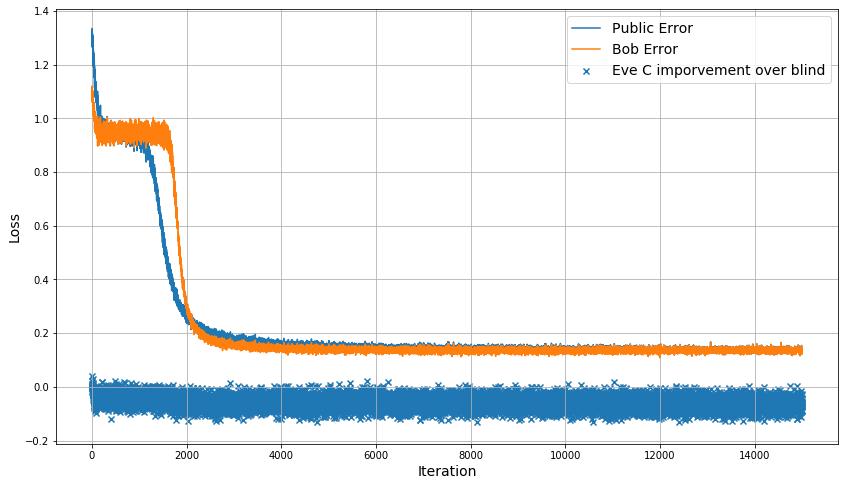

In [65]:
plt.figure(figsize=(14,8))
#plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
#plt.plot(range(1, len(Es)+1), Es, label='Eve')
plt.scatter(range(1, len(E_improvement)+1), E_improvement, marker='x', label='Eve C imporvement over blind')
plt.plot(range(1, len(PEs)+1), PEs, label='Public Error')
plt.plot(range(1, len(BEs)+1), BEs, label='Bob Error')
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which='both')
plt.show()